<h1><center> Web scraping multiple job platforms with Selenium & BeautifulSoup and aggregating the job offers in an interactive Bokeh dashboard </center></h1>

<img src='Images/Capture_bokeh_2.png' width="1000" height="1000" align="center"/>

<h2><u>Context and objectives</u></h2>

This notebook is focused on a personal project which aims at centralizing in a single app my job searches on several online job boards. To date, in the framework of this project, "only" the APEC and Indeed job websites have been scraped and the job search queries have been restricted to data-related positions in France. 
<br>

This project can be divided into three tasks with distinct purposes. 
<br>
The first chapter of the notebook tackles in details the web scraping exercise with the Python libraries Selenium and BeautifulSoup while the second one is specifically dedicated to the construction of the personal job dashboard using the Bokeh library. Finally, the last task will consist in an exploratory data analysis of all the information collected in order to have an overall picture of the data-related job market in France and enlighten the most valuable and sought-after soft and hard skills.
<br>
<br>
<u>*Key skills:*</u>
<br>
**Unstructured data**, **Web scraping**, **Text mining**, **Dataviz**, **Text similarity metrics**
<br>
<u>*Key libraries:*</u>
<br>
**Selenium**, **BeautifulSoup**, **Bokeh**, **Pandas**, **Re**

***
<h2><center><u>Table of contents</u></center></h2>

[<h3>I) Web scraping the job boards</h3>](#1)
[<h4>1) APEC job board </h4>](#1.1)
[<h5>&emsp;a) Step by step approach </h5>](#1.1.a) 
[<h5>&emsp;b) All in one functions </h5>](#1.1.b)  
[<h4>2) Indeed job board </h4>](#1.2)
[<h5>&emsp;a) Step by step approach </h5>](#1.2.a)
[<h5>&emsp;b) All in one functions </h5>](#1.2.b)
<br>
[<h3>II) Using Bokeh to build a custom aggregated job board</h3>](#2)
[<h4>1) Preprocessing the raw data </h4>](#2.1)
[<h5>&emsp;a) Data cleaning </h5>](#2.1.a)
[<h5>&emsp;b) Feature engineering </h5>](#2.1.b)
[<h5>&emsp;c) All in one function </h5>](#2.1.c)
<br>
[<h4>2) Custom aggregated job board using Bokeh </h4>](#2.2)
[<h5>&emsp;a) Bokeh App architecture </h5>](#2.2.a)
[<h5>&emsp;a) Bokeh App </h5>](#2.2.b)
<br>
[<h3>III) Exploratory data analysis (on going...)</h3>](#3)
***

<h2>I) Web scraping the job boards</h2>
<a id="1"></a>

For dynamic web scraping I used the powerful library combination of Selenium and BeautifoulSoup. BeautifoulSoup would be self-sufficient for static scraping but does not handle Javascript components and could not deal with the few necessary event-action for the targeted website (e.g. closing a popup, navigating to next page, scroll down the page to display its full content ...)
<br>
Selenium allows web browser interactions/navigation directly from Python via a chosen web driver and can also fetch the HTML page source for the current DOM of a website. Afterwards, BeautifulSoup can perform the parsing job of the document using a custom parser (here "lxml").
<br>
<br>
For furter information on how to install and use these libraries, please read the available documentations [[1]](#ref1), [[2]](#ref2).
Other usefull contents browsed during my journey through web scraping : [[3]](#ref3), [[4]](#ref4), [[5]](#ref4), [[6]](#ref6), [[7]](#ref7).
<br>
<br>
<u>*Prior to scrape a website, its general terms of use should be checked.*</u>


<h3>1) APEC job board</h3>
<a id="1.1"></a>

<h4>a) Step by step approach</h4>
<a id="1.1.a"></a>

For the APEC job board, the process of retrieving the target information from unstructured data will be presented step by step. Feel free to directly move to the next section if you are already familiar with Selenium and BeautifulSoup. 
<br>
Please not that APEC is a French job board and that some information will be displayed in french.
<br>
<br>
First, let's import all the necessary libaries for the Notebook.

In [1]:
import os
import sys
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)
import glob
import time
import datetime
import random
import string
import re
import pickle

import selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select
from six.moves import urllib
import bs4
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import scipy
from scipy.sparse import vstack
import seaborn as sns

import sklearn
from sklearn.feature_extraction.text import CountVectorizer 

import bokeh

from IPython.display import display, Image

In [2]:
print("Python version: ", sys.version)
print("Numpy version: ", np.__version__)
print("Scipy version: ", scipy.__version__)
print("Pandas version: ", pd.__version__)
print("Scikit-learn version: ", sklearn.__version__)
print("Seaborn version: ", sns.__version__)
print("Selenium version: ", selenium.__version__)
print("BeautifulSoup version: ", bs4.__version__)
print("Bokeh version: ", bokeh.__version__)

Python version:  3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]
Numpy version:  1.16.4
Scipy version:  1.3.0
Pandas version:  0.24.2
Scikit-learn version:  0.21.2
Seaborn version:  0.9.0
Selenium version:  3.141.0
BeautifulSoup version:  4.7.1
Bokeh version:  1.3.0


We need to define and initiate our Selenium web driver. Headless option is removed here in order to see what we are actually doing.

In [3]:
options = webdriver.ChromeOptions()
options.add_argument('--ignore-certificate-errors')
options.add_argument('--incognito')
#options.add_argument('--headless')
driver = webdriver.Chrome(options=options)

In [4]:
some_url = "https://cadres.apec.fr/home/mes-offres-d-emploi.html"
driver.get(some_url)
time.sleep(2)
driver.find_element_by_xpath("//button[@title='Accepter']").click() #cookie popup

<img src='Images/Capture_apec_query.png' width="600" height="600" align="center"/>

Selenium allows you to find and access elements of a web page according to multiple ways (report to documentation). Here, all we need to do is access to two elements : What position we are looking for and Where. 
<br>
To easily find the proper information to access the different elements : Right click > Inspect element (manually)
<br> 
As mentionned earlier, Selenium replicate all the intereactions a "real end-user" could have with its web brower. Here we clear the two blank fields and enter our proposition. Finally we press Enter Key while being in the location field to initiate our query.

In [5]:
kw_elem = driver.find_element_by_id("keywords")
kw_elem.clear()
kw_elem.send_keys('data scientist OU data analyst')
loc_elem = driver.find_element_by_xpath("//input[@placeholder='Ex : Paris, Lyon ...']")
loc_elem.clear()
loc_elem.send_keys('Auvergne-Rhône-Alpes', Keys.RETURN)

<img src='Images/Capture_apec_results_51.png' width="600" height="600" align="center"/>

Our next step is to collect all the job offer links returned by our query for every page of results. 
<br>
Just one subtility : to display the "Next" Button to navigate between the pages, we first need to scroll down to the page bottom. 

In [6]:
page_nb = 1
job_links = []
while True:
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    job_titles = driver.find_elements_by_class_name('offre-title')
    for i in range(len(job_titles)):
        job_link = job_titles[i].find_element_by_css_selector('a').get_attribute('href')
        job_links.append(job_link)
    try:
        next_page = driver.find_element_by_link_text('Suiv.').click()
        page_nb += 1
        print("Navigating to next page ({})".format(page_nb))
    except:
        print("\n All the pages ({}) have been read through".format(page_nb))
        break

Navigating to next page (2)
Navigating to next page (3)

 All the pages (3) have been read through


In [7]:
len(job_links)

51

Everything seems fine. We are almost done with Selenium. 
<br> 
The last action consists in fetching the source code of every webpage stored in our job_links list. Let's move on to the parsing exercise with BeautifulSoup. As adviced by the documentation, I installed and used the lxml parser for speed.

In [8]:
some_offer = job_links[0]
driver.get(some_offer)
page_source = driver.page_source

In [9]:
soup = BeautifulSoup(page_source, 'lxml')

BeautifoulSoup provides a lot of means and alternatives to navigate through the DOM and retrieve the desired elements. Please, read the documentation for further information on how navigating/searching the tree and manipulating the different kind of objects. Like for Selenium, left-click > Inspect element, will be our best option to identify the target information.

<img src='Images/Capture_apec_offer.png' width="700" height="700" align="center"/>

In [10]:
ref = soup.find(string=re.compile('Ref\. Apec'))
re.findall("\d+\w*", ref)[0]

'164421518W'

In [11]:
job_title = soup.find('h1', class_="text-uppercase ng-binding").text
job_title

'Data Scientist F/H'

In [12]:
comp_and_loc = soup.find_all('strong', class_="ng-binding")
compagny, location = comp_and_loc[1].text, comp_and_loc[2].text
compagny, location

('DataGenius', 'Lyon 03 - 69')

In [13]:
pos_type = soup.find('span', class_="ng-binding ng-scope").text
nb_pos = next(soup.find('span', class_="ng-binding ng-scope").parent.stripped_strings)
pos_type, nb_pos

('CDI', '2')

In [14]:
pub_date = re.findall("(?:/*\\d+)+", soup.find(string=re.compile('Publiée le')))[0]
act_date = re.findall("(?:/*\\d+)+", soup.find(string=re.compile('Actualisée le')))[0]
pub_date, act_date

('18/07/2019', '18/07/2019')

BeautifulSoup also accepts function for tag. Here we want to retrieve all "strong" tag objects with no "class" attribute. 

In [15]:
def tag_strong_but_no_class(tag):
    return (tag.name == "strong") and not(tag.has_attr('class'))

In [16]:
full_info = soup.find_all(tag_strong_but_no_class)
full_info

[<strong>Salaire :</strong>,
 <strong>Prise de poste :</strong>,
 <strong>Expérience dans le poste :</strong>,
 <strong>Statut du poste :</strong>,
 <strong>Zone de déplacement :</strong>,
 <strong>Secteur d’activité du poste :</strong>,
 <strong>Client :</strong>,
 <strong>R&amp;D :</strong>,
 <strong>DataGenius</strong>,
 <strong>Intelligence Artificielle</strong>,
 <strong>Machine Learning et Big Data</strong>,
 <strong>Data Science et Intelligence Artificielle sont au cœur d'une rupture sociétale et économique majeure</strong>,
 <strong>start-up dynamique et bienveillante</strong>,
 <strong>porteuse de projets stimulants et innovants</strong>,
 <strong>Personne en charge du recrutement :</strong>]

In [17]:
full_info[0].next_sibling

' A partir de 36 k€ brut annuel'

In [18]:
relevant_info_l = ['salary', 'empl_date', 'req_exp', 'pos_stt', 'btrip_area', 'act_area']
relevant_info_d = {}
for idx, info in enumerate(relevant_info_l):
    relevant_info_d[info] = full_info[idx].next_sibling
    
relevant_info_d['req_exp']

" Tous niveaux d'expérience acceptés"

Now we will retrieve the longer text objects for the description of the position, the required profile, the entreprise and the recruitment process. Let's first try with the position description and then build a function to retrieve all these elements.

In [19]:
pos_descr = soup.find(id='descriptif-du-poste')
pos_descr_txt = "\n".join(pos_descr.stripped_strings) #generator
print(pos_descr_txt)

Descriptif du poste
En rejoignant DataGenius, vous jouerez un rôle-clé dans le développement technique de l’entreprise, et exploiterez notre formidable potentiel de croissance.
Intégré au sein d’une équipe expérimentée, vous serez amené à intervenir sur deux types de missions :
Client :
Vous participerez à la mise en place de modèles de machine et deep Learning pour des clients, les tester et les mettre en production. Vous serez amené à vous adapter aux problématiques et au métier des clients, mais aussi faire preuve d’une autonomie dans l’analyse des données qui vous seront fournis et la mise en place d’un modèle qui répond aux objectifs qui vous seront définis.
R&D :
Vous contribuerez au développement des différents modules de​ Atlas (NLP, Auto-ML, exploitation de l’Open Data, mise en place d’API, etc.) :
Effectuer une étude bibliographique sur l'état de l’art concernant le module choisi
Proposer une solution adéquate
Définir le protocole expérimental (les données à utiliser, la fonc

In [20]:
def fetch_txt_from_soup(id_txt, soup):
    """Take a soup object and an id and return the full text corresponding to the section"""
    elem = soup.find(id=id_txt)
    if elem != None:
        elem_txt = "\n".join(elem.stripped_strings) #generator
        if id_txt == 'entreprise': #noisy text
            elem_txt = re.sub("\nAutres offres de l'entreprise", '', elem_txt)
        elif id_txt == 'processus-de-recrutement': #noisy text
            elem_txt = re.sub('\n?.*POSTULER.*\nImprimer\nSignaler cette offre', '', 
                              elem_txt)
        return elem_txt
    else:
        return ''

In [21]:
id_in_l = ['descriptif-du-poste', 'profil-recherche', 'entreprise', 'processus-de-recrutement']
id_out_l = ['pos_descr', 'profil', 'comp_info', 'recruit_proc']

for id_in, id_out in zip(id_in_l, id_out_l):
    relevant_info_d[id_out] = fetch_txt_from_soup(id_in, soup)

In [22]:
print(relevant_info_d['profil'])

Profil recherché
De niveau Bac+4/5 ou équivalent en école d'ingénieur, vous possédez une spécialisation en mathématiques appliquées, statistiques, machine learning ou intelligence artificielle.
Vous affichez des capacités à manipuler et traiter des données en provenance de sources diverses.
Vous démontrez du goût pour la résolution de problèmes par des approches quantitatives en se formant sur des techniques avancées de Machine Learning.
Vous avez la volonté de rejoindre une aventure entrepreneuriale avec une équipe ambitieuse, tournée vers l’innovation.
Une bonne maîtrise de l’anglais est indispensable.
Vous maîtrisez l'utilisation de  Git, Python (Scikit-learn, Numpy, Pandas, Keras, Tensorflow) et optionnellement Linux, Docker, Django, Spark.


And finally, the recruitment responsible (if provided).

In [23]:
elem = soup.find('i')
try:
    recruit_resp = elem.previous_element + elem.text
except Exception as e:
    print(e)
    recruit_resp=''

recruit_resp

'Taha Zemmouri - Président'

***
**This is pretty much everything we need to do to scrap the APEC job board.
<br> The only thing left is to define some nice functions to proceed the whole step by step approach and build our own job database.**

<h4>b) All in one functions</h4>
<a id="1.1.b"></a>

Let's define 3 main functions to handle the full web scraping process and build our own databe :
* 1st : initiate the webdrive and request the job platform on position key words and location and precise a sorting option for the result;
* 2nd : take the driver returned by the first function and browse all the result pages to fetch the URL of every job offer;
* 3rd : load source code of every web page provided by the second function, scrape it with BeautifulSoup and store the information in a list of dictionnaries (in anticipation of the coming dataframe). 

Nothing special to mention for these 3 functions in comparison to the previous step by step presentation. I just added some time.sleep() in the code because of a few erros I encountered while dealing with bigger data. This prevents server overwhelming, allows the page to fully load/wait for a specific element to appear.

In [24]:
ROOT_URL = "https://cadres.apec.fr/home/mes-offres-d-emploi.html"
JOB_KW = "data scientist OU data analyst"

In [25]:
DB_SAVING_DIR = './job_db'
os.makedirs(DB_SAVING_DIR, exist_ok=True)
DB_APEC_SAVING_PATH = os.path.join(DB_SAVING_DIR, 'apec_db.xlsx')
DB_APEC_NEW_SAVING_PATH = os.path.join(DB_SAVING_DIR, 'apec_new.xlsx') #save also new offer in a seperate file for late

In [26]:
def request_apec_platform(root_url=ROOT_URL, job_kw=JOB_KW, job_loc=None,
                          sort_by='Pertinence'):
    """Initiate the webdrive and request the job platform on position key words and location and
    precise a sorting option for the result"""
    global driver
    try:
        driver.quit()
    except:
        pass
    options = webdriver.ChromeOptions()
    options.add_argument('--ignore-certificate-errors')
    options.add_argument('--incognito')
    options.add_argument('--headless')
    options.add_argument("--window-size=1366, 768")
    driver = webdriver.Chrome(options=options)
    driver.get(root_url)
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(2)
    try:
        driver.find_element_by_xpath("//button[@title='Accepter']").click() #cookie popup
        time.sleep(2)
    except:
        pass
    kw_elem = driver.find_element_by_id("keywords")
    kw_elem.clear()
    kw_elem.send_keys(job_kw)
    if job_loc != None:
        loc_elem = driver.find_element_by_xpath("//input[@placeholder='Ex : Paris, Lyon ...']")
        loc_elem.clear()
        loc_elem.send_keys(job_loc, Keys.RETURN)
    else:
        driver.find_element_by_class_name('btn-block').click()
    sort_by_el = driver.find_element_by_link_text(sort_by)
    sort_by_el.click()
    print("Job search request was performed on:\n"
          "Job title: {}, Job location: {}, sorted by {}".format(job_kw, job_loc, sort_by))
    return driver

In [27]:
def fetch_apec_job_links(driver=driver, old_db_path=DB_APEC_SAVING_PATH, 
                           max_consec_existing_link=40):
    """Take the driver request and browse all the result pages to fetch the URL of every job offer"""
    page_nb = 1
    job_links = []
    consec_existing_link = 0
    update = os.path.isfile(old_db_path)
    if update is True:
        print('A previous database already exists. Only new job links will be fetched')
        old_db = pd.read_excel(old_db_path)
        old_job_links = old_db['url'].to_list()
    while True:
        time.sleep(1)
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(1)
        job_titles = driver.find_elements_by_class_name('offre-title')
        for i in range(len(job_titles)):
            job_link = job_titles[i].find_element_by_css_selector('a').get_attribute('href')
            job_link = re.split('&totalCount', job_link)[0]
            if (update is False) or (job_link not in old_job_links):
                job_links.append(job_link)
                consec_existing_link = 0
            else:
                consec_existing_link += 1
                if consec_existing_link >= max_consec_existing_link:
                    print("\nNo more new links to retrieve")
                    break  
        try:
            assert consec_existing_link < max_consec_existing_link
            next_page = driver.find_element_by_link_text('Suiv.').click()
            page_nb += 1
            print("Navigating to next page ({})".format(page_nb))
        except:
            print("\nAll the pages ({}) have been read through".format(page_nb))
            break
    return job_links

In [28]:
def scrapping_apec_offers(job_links, parser='lxml', LIMIT=None):
    """Load source code of every web page from the URL job_links list, scrape it with BeautifulSoup 
    and store the information in a list of dictionnaries"""
    global driver
    try:
        driver.quit()
    except:
        pass
    options = webdriver.ChromeOptions()
    options.add_argument('--ignore-certificate-errors')
    options.add_argument('--incognito')
    options.add_argument('--headless')
    options.add_argument("--window-size=1366, 768")
    driver = webdriver.Chrome(options=options)
    job_parser_l = []
    relevant_info_l = ['salary', 'empl_date', 'req_exp', 'pos_stt', 'btrip_area', 'act_area']
    id_in_l = ['descriptif-du-poste', 'profil-recherche', 'entreprise', 
               'processus-de-recrutement']
    id_out_l = ['pos_descr', 'profil', 'comp_info', 'recruit_proc']
    for x, link in enumerate(job_links[:LIMIT]):
        size = len(job_links)
        if x % 100 == 0:
            print('\n{} offers have been parsed out of {}'.format(x, size))
        try:
            job_parser_d = {}
            driver.get(link)
            page_source = driver.page_source
            soup = BeautifulSoup(page_source, parser)
            ref = soup.find(string=re.compile('Ref\. Apec'))
            job_parser_d['ref_site'] = re.findall("Ref. Apec : (\d*\w*)", ref)[0]
            ref = soup.find(string=re.compile('Ref\. Société'))
            if ref != None:
                job_parser_d['ref_comp'] = re.findall("Ref. Société : (\d*\w*)", ref)[0]
            else:
                job_parser_d['ref_comp'] = ''
            job_title = soup.find('h1', class_="text-uppercase ng-binding").text
            job_parser_d['job_title'] = re.sub(' F/H', '', job_title)
            comp_and_loc = soup.find_all('strong', class_="ng-binding")
            job_parser_d['company'] = comp_and_loc[1].text
            job_parser_d['location'] = comp_and_loc[2].text
            pos_type = soup.find('span', class_="ng-binding ng-scope")
            job_parser_d['pos_type'] = pos_type.text
            job_parser_d['nb_pos'] = next(pos_type.parent.stripped_strings)
            pub_date = re.findall("(?:/*\\d+)+", soup.find(string=re.compile('Publiée le')))[0]
            job_parser_d['pub_date'] = pub_date
            act_date = re.findall("(?:/*\\d+)+", soup.find(string=re.compile('Actualisée le')))[0]
            job_parser_d['act_date'] = act_date
            pos_info = soup.find_all(tag_strong_but_no_class)
            for idx, info in enumerate(relevant_info_l):
                job_parser_d[info] = pos_info[idx].next_sibling            
            for id_in, id_out in zip(id_in_l, id_out_l):
                job_parser_d[id_out] = fetch_txt_from_soup(id_txt=id_in, soup=soup)
            recruiter = soup.find('i')
            try:
                recruit_resp = recruiter.previous_element + recruiter.text
            except :
                recruit_resp = ''
            job_parser_d['recruit_resp'] = recruit_resp
            job_parser_d['url'] = link
                        
            job_parser_l.append(job_parser_d)
        except:
            print('\n', '~-'*20, 'WARNING', '~-'*20,
            '\nAn issue was encountered with an offer. It might probably be no longer'
                ' available at the parsing time.',
            '\nAs a result this offer could not be added to the database. '
            'You should investigate job_link number {}'.format(x),
            '\n', '~-'*20, 'WARNING', '~-'*20)
    print("\nAll the offers have been processed")
    return job_parser_l

Finally, wrap these three functions into one to perform the full web scraping process and create/update the APEC job database. Here I chose to work with a simple Excel file but a real relational database could be a better option (in particular to feed and update the database !). 
<br> Let's first define a short function to feed an excel file with new recordings.

In [29]:
def update_excel_file(old_file_path, new_df):
    """Feed new recordings from a dataframe to an old excel file with same format"""
    df_db = pd.read_excel(old_file_path)
    df_full = df_db.append(new_df, ignore_index=True)
    with pd.ExcelWriter(old_file_path, options={'strings_to_urls': False}) as writer:
            df_full.to_excel(writer, index=False)
    return df_full

In [30]:
def update_apec_db(db_path=DB_APEC_SAVING_PATH, new_file_path=DB_APEC_NEW_SAVING_PATH):
    """Perform the full web scraping process and create/update the APEC database"""
    driver = request_apec_platform(sort_by='Date')
    time.sleep(1)
    job_links_new = fetch_apec_job_links(driver=driver, old_db_path=db_path)
    print('{} new offers were founded and will be parsed'.format(len(job_links_new)))
    new_job_parser = scrapping_apec_offers(job_links=job_links_new)
    df_apec_new = pd.DataFrame(new_job_parser)
    update = os.path.isfile(db_path)
    if update:
        df_apec_full = update_excel_file(db_path, df_apec_new)
        with pd.ExcelWriter(new_file_path, options={'strings_to_urls': False}) as writer:
            df_apec_new.to_excel(writer, index=False)
        print('\nDone: the new offers have been saved and added to the APEC DB')
        return df_apec_full
    else:
        with pd.ExcelWriter(db_path, options={'strings_to_urls': False}) as writer:
            df_apec_new.to_excel(writer, index=False)
        print('\nDone: the APEC DB has been created and the offers have been saved')
        return df_apec_new

In [31]:
df_apec_full = update_apec_db()

Job search request was performed on:
Job title: data scientist OU data analyst, Job location: None, sorted by Date
A previous database already exists. Only new job links will be fetched
Navigating to next page (2)
Navigating to next page (3)
Navigating to next page (4)
Navigating to next page (5)

No more new links to retrieve

All the pages (5) have been read through
17 new offers were founded and will be parsed

0 offers have been parsed out of 17

All the offers have been processed

Done: the new offers have been saved and added to the APEC DB


In [32]:
display(df_apec_full.head())

,act_area,act_date,btrip_area,comp_info,company,empl_date,job_title,location,nb_pos,pos_descr,...,pos_type,profil,pub_date,recruit_proc,recruit_resp,ref_comp,ref_site,req_exp,salary,url
0,Conseil pour les affaires et autres conseils ...,15/05/2019,Pas de déplacement,Entreprise\nNous cherchons pour notre client d...,MINEO,Dès que possible,Data Analyst/Scientist,Aix-en-Provence - 13,1,Descriptif du poste\nAmené à travailler sur de...,...,CDI,Profil recherché\nDe ce fait nous recherchons ...,11/04/2019,Processus de recrutement\nPersonne en charge d...,Grégoire CLEMENT - Founder,NaN,164141813W,Minimum 3 ans,A partir de 40 k€ brut annuel,https://cadres.apec.fr/offres-emploi-cadres/0_...
1,Conseil en systèmes et logiciels informatiques,15/05/2019,Départementale,Entreprise\nModis recrute 1000 Talents en 2019...,MODIS FRANCE,Dès que possible,Consultant Data analyst / Data scientist,Toulouse - 31,1,Descriptif du poste\nVous souhaitez côtoyer au...,...,CDI,Profil recherché\nDe formation Bac+5/ Ingénieu...,15/05/2019,Processus de recrutement\nPersonne en charge d...,Lory Lo Moro - Recruteur,MID,164236918W,Minimum 1 an,A négocier,https://cadres.apec.fr/offres-emploi-cadres/0_...
2,Autre mise à disposition de ressources humaines,03/06/2019,Départementale,Entreprise\nNous sommes un cabinet de conseil ...,ATHANOR INFORMATIQUE,Dès que possible,DATA ANALYST / DATA SCIENTIST,Suresnes - 92,1,Descriptif du poste\nData Analyst/ Data Scient...,...,CDI,Profil recherché\nData Analyst/ Data Scientist...,03/06/2019,Processus de recrutement\nNous recevrons les c...,THIERRY JOUDELAT - Direction,DATA,164266817W,Minimum 2 ans,A négocier,https://cadres.apec.fr/offres-emploi-cadres/0_...
3,Conseil pour les affaires et autres conseils ...,29/05/2019,Pas de déplacement,Entreprise\nEasy Partner fait aujourd'hui part...,EASY PARTNER,Dès que possible,Data Scientist,Paris 02 - 75,1,Descriptif du poste\nLa société :\nNotre clien...,...,CDI,Profil recherché\nLe profil :\nVous maîtrisez ...,29/05/2019,Processus de recrutement\nPersonne en charge d...,. Masson - Consultant en recrutement,NaN,164259645W,Minimum 1 an,40 - 45 k€ brut annuel,https://cadres.apec.fr/offres-emploi-cadres/0_...
4,Conseil pour les affaires et autres conseils ...,29/05/2019,Régionale,"Entreprise\nDu plaisir à faire son travail, da...",SIDERLOG,Dès que possible,Data Scientist,Niort - 79,1,Descriptif du poste\nPour renforcer son équipe...,...,CDI,"Profil recherché\nDe formation décisionnelle, ...",29/05/2019,Processus de recrutement\nPersonne en charge d...,Françoise LEGER - Assistante chargée de recrut...,Data,164279571W,Minimum 5 ans,A négocier,https://cadres.apec.fr/offres-emploi-cadres/0_...


In [33]:
display(df_apec_full.tail())

,act_area,act_date,btrip_area,comp_info,company,empl_date,job_title,location,nb_pos,pos_descr,...,pos_type,profil,pub_date,recruit_proc,recruit_resp,ref_comp,ref_site,req_exp,salary,url
1802,Études de marché et sondages,14/08/2019,Pas de déplacement,"Entreprise\nIRI, le leader mondial dans les do...",INFORMATION RESOURCES,Dès que possible,CHARGE(E) D’ETUDES – Service Modèles IRI – Ch...,Chambourcy - 78,1,Descriptif du poste\nIRI recherche un(e) Charg...,...,CDI,Profil recherché\nVous êtes diplômé(e) d’un BA...,14/08/2019,Processus de recrutement\nPersonne en charge d...,Solene Lavergne - Responsable RH,,164480915W,Tous niveaux d'expérience acceptés,34 - 40 k€ brut annuel,https://cadres.apec.fr/offres-emploi-cadres/0_...
1803,Conseil pour les affaires et autres conseils ...,14/08/2019,Internationale,Entreprise\nAdoc Talent Management recrute un·...,ADOC TALENT MANAGEMENT,Dès que possible,Chef·fe d'équipe développement,Paris 12 - 75,1,Descriptif du poste\nEn lien direct avec le C....,...,CDI,Profil recherché\nTitulaire d’un diplôme d’ing...,26/07/2019,Processus de recrutement\nPersonne en charge d...,Faustine Bizet - Consultante en Recrutement,,164441597W,Minimum 3 ans,A négocier,https://cadres.apec.fr/offres-emploi-cadres/0_...
1804,Conseil en systèmes et logiciels informatiques,14/08/2019,Pas de déplacement,"Entreprise\nAlligator, est une société au cœur...",ALLIGATOR,Dès que possible,Expert Azure DevOps,Valbonne - 06,1,Descriptif du poste\nMission\nVous évoluerez d...,...,CDI,Profil recherché\nProfil\nDiplôme supérieur da...,14/08/2019,Processus de recrutement\nPersonne en charge d...,Céline Grimaldi - Responsable RH & recrutement,,164480855W,Minimum 4 ans,A négocier,https://cadres.apec.fr/offres-emploi-cadres/0_...
1805,Conseil en systèmes et logiciels informatiques,14/08/2019,Pas de déplacement,Entreprise\nQUI SOMMES-NOUS ?\nADONIS est une ...,ADONIS,Dès que possible,Lead Technique Hadoop - Big Data,Paris 08 - 75,1,Descriptif du poste\nDescription de la mission...,...,CDI,Profil recherché\nProfil recherché :\nVous pré...,14/08/2019,Processus de recrutement\nProcess RH ADONIS :\...,AGNES LACOMBE - DRH,LT_HADOOP_BIGDATA_140819,164480795W,Minimum 2 ans,40 - 50 k€ brut annuel,https://cadres.apec.fr/offres-emploi-cadres/0_...
1806,Conseil en systèmes et logiciels informatiques,14/08/2019,Pas de déplacement,Entreprise\nQUI SOMMES-NOUS ?\nADONIS est une ...,ADONIS,Dès que possible,Data Scientist,Paris 08 - 75,1,Descriptif du poste\nDans le cadre de notre dé...,...,CDI,Profil recherché\nProfil recherché :\nDe forma...,14/08/2019,Processus de recrutement\nProcess RH ADONIS :\...,AGNES LACOMBE - DRH,DATA_SCIENT_AS_140819,164480667W,Minimum 5 ans,40 - 55 k€ brut annuel,https://cadres.apec.fr/offres-emploi-cadres/0_...


<h3>2) Indeed job board</h3>
<a id="1.2"></a>

<h4>a) Step by step approach</h4>
<a id="1.2.a"></a>

The step by step process for the Indeed jo board would basically alike the one for the APEC job board (even much simpler since the indeed offers contain less info and are not as well organised). Let's directly move to the all in one chapter. 
<br> 
Please not that I use the French site version for Indeed and that a few information might be in french too.

<h4>b) All in one functions</h4>
<a id="1.2.b"></a>

Exactly like for the APEC job board, let's define 3 main functions to handle the full web scraping process and build our own databe :
* 1st : initiate the webdrive and request the job platform on position key words and location and precise a sorting option for the result;
* 2nd : take the driver returned by the first function and browse all the result pages to fetch the URL of every job offer;
* 3rd : load source code of every web page provided by the second function, scrape it with BeautifulSoup and store the information in a list of dictionnaries (in anticipation of the coming dataframe). 

Here too I added some time.sleep() in the code because of a few erros I encountered while dealing with bigger data. This prevents server overwhelming, allows the page to fully load/wait for a specific element to appear.

In [34]:
ROOT_URL = "https://www.indeed.fr/advanced_search"
JOB_KW = "data" # allow to scrap on job title on Indeed :)
JOB_LOC = 'France'
NB_PER_PAGE = '50'
DB_INDEED_SAVING_PATH = os.path.join(DB_SAVING_DIR, 'indeed_db.xlsx')
DB_INDEED_NEW_SAVING_PATH = os.path.join(DB_SAVING_DIR, 'indeed_new.xlsx') #save also new offer in a seperate file 

In [35]:
def request_indeed_platform(root_url=ROOT_URL, job_kw=JOB_KW, job_loc=None, 
                            lim=NB_PER_PAGE, sort_by='pertinence'):
    """Initiate the webdrive and request the job platform on position key words and location and
    precise a sorting option for the result"""
    global driver
    try:
        driver.quit()
    except:
        pass
    options = webdriver.ChromeOptions()
    options.add_argument('--ignore-certificate-errors')
    options.add_argument('--incognito')
    #options.add_argument('--headless')
    #options.add_argument("--window-size=1366, 768")
    driver = webdriver.Chrome(options=options)
    driver.get(root_url)
    try:   
        driver.find_element_by_css_selector("[class='tos-Button tos-Button-white']").click()
        time.sleep(1)
    except:
        pass 
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    kw_elem = driver.find_element_by_id("as_ttl")
    kw_elem.clear()
    kw_elem.send_keys(job_kw)
    nb_per_page = Select(driver.find_element_by_id('limit'))
    nb_per_page.select_by_visible_text(lim)
    sort_by_el = Select(driver.find_element_by_id('sort'))
    sort_by_el.select_by_visible_text(sort_by)
    if job_loc != None:
        loc_elem = driver.find_element_by_id("where")
        loc_elem.clear()
        loc_elem.send_keys(job_loc, Keys.RETURN)
    else:
        driver.find_element_by_id('fj').click()
    print("Job search request was performed on:\n"
          "Job title: {}, Job location: {}, sorted by {}".format(job_kw, job_loc, sort_by))
    return driver

In [36]:
def fetch_indeed_job_links(driver=driver, old_db_path=DB_INDEED_SAVING_PATH, 
                           max_consec_existing_link=40):
    """Take the driver request and browse all the result pages to fetch the URL of every job offer"""
    page_nb = 1
    job_links = []
    consec_existing_link = 0
    update = os.path.isfile(old_db_path)
    if update is True:
        print('A previous database already exists. Only new job links will be fetched')
        old_db = pd.read_excel(old_db_path)
        old_job_links = old_db['url'].to_list()
    while True:
        time.sleep(random.randint(10, 30))
        try:
            popup = driver.find_element_by_class_name('icl-CloseButton')
            popup.click() #close popup
        except:
            pass
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        job_titles = driver.find_elements_by_class_name("title")
        for i in range(len(job_titles)):
            job_link = job_titles[i].find_element_by_css_selector('a').get_attribute('href')
            if (update is False) or (job_link not in old_job_links):
                job_links.append(job_link)
                consec_existing_link = 0
            else:
                consec_existing_link += 1
                if consec_existing_link >= max_consec_existing_link:
                    print("\nNo more new links to retrieve")
                    break  
        try:
            assert consec_existing_link < max_consec_existing_link
            next_page = driver.find_element_by_link_text('Suivant »').click()
            page_nb += 1
            print("Navigating to next page ({})".format(page_nb))
        except:
            print("\nAll the pages ({}) have been read through".format(page_nb))
            break
    return job_links

In [37]:
def indeed_delta_to_date(soup):
    """Change the Indeed very unconvenient delta date (e.g : "One hour ago", "two weeks ago") into a classic one"""
    job_age = soup.find("div", class_='jobsearch-JobMetadataFooter').text
    if job_age == None:
        return ''
    else:
        digits = re.findall('(\d+)\+?\s(?:jours?|heures?|mois?)', job_age)[0]
        now = datetime.datetime.now()
        match = re.search('heure', job_age)
        if match != None:
            date = now - datetime.timedelta(hours=int(digits))
        elif re.search('jour', job_age) != None:
            date = now - datetime.timedelta(days=int(digits))
        else:
            date = now - datetime.timedelta(days=30)
        return date.strftime('%d/%m/%Y')

In [38]:
def scrapping_indeed_offers(job_links, parser='lxml', LIMIT=None):
    """Load source code of every web page from the URL job_links list, scrape it with BeautifulSoup 
    and store the information in a list of dictionnaries"""
    icons_l = ['icl-IconFunctional icl-IconFunctional--location icl-IconFunctional--md',
               'icl-IconFunctional icl-IconFunctional--jobs icl-IconFunctional--md',
               'icl-IconFunctional icl-IconFunctional--salary icl-IconFunctional--md']
    att_out_l = ['location', 'pos_type', 'salary']
    job_parser_l = []
    while True:
        global driver
        try:
            driver.quit()
        except:
            pass
        options = webdriver.ChromeOptions()
        options.add_argument('--ignore-certificate-errors')
        options.add_argument('--incognito')
        #options.add_argument('--headless')
        #options.add_argument("--window-size=1366, 768")
        driver = webdriver.Chrome(options=options)
        some_link = job_links[random.randint(0, len(job_links))]
        driver.get(some_link)
        page_source = driver.page_source
        soup = BeautifulSoup(page_source, parser)
        elem = soup.find(class_=icons_l[0])
        if elem == None:
            print('Webpage not displayed correctly, restarting the web driver')
        else:
            print('\nWebpage displayed correctly, parsing will start... :)')
            break
   
    for x, link in enumerate(job_links[:LIMIT]):
        size = len(job_links)
        if x % 100 == 0:
            print('\n{} offers have been parsed out of {}'.format(x, size))
        try:
            job_parser_d = {}
            driver.get(link)
            page_source = driver.page_source
            soup = BeautifulSoup(page_source, parser)
            job_title = soup.find('h3').text
            job_parser_d['job_title'] = re.sub('\s+[-(]?\s?(?:F/H|H/F)\)?', '', 
                                               job_title, flags=re.IGNORECASE)
            comp = soup.find('div', class_='icl-u-lg-mr--sm icl-u-xs-mr--xs')
            job_parser_d['company'] = comp.text
            for icon, att_out in zip(icons_l, att_out_l):
                elem = soup.find(class_=icon)
                if elem!=None:
                    job_parser_d[att_out] = elem.next_sibling.text
                else:
                    job_parser_d[att_out] = ''
            pos_descr = soup.find(id='jobDescriptionText')
            job_parser_d['pos_descr'] = pos_descr.text
            job_parser_d['pub_date'] = indeed_delta_to_date(soup=soup)
            job_parser_d['url'] = link                     
            job_parser_l.append(job_parser_d)
        except:
            print('\n', '~-'*20, 'WARNING', '~-'*20,
            '\nAn issue was encountered with an offer. It might probably be no longer'
                ' available at the parsing time.',
            '\nAs a result this offer could not be added to the database. '
            'You should investigate job_link number {}'.format(x),
            '\n', '~-'*20, 'WARNING', '~-'*20)
    print("\nAll the offers have been processed")
    return job_parser_l

Again, wrap these three functions into one to perform the full web scraping process and create/update the Indeed job database. Here I chose to work with a simple Excel file but a real relational database could be a better option.

In [39]:
def update_indeed_db(db_path=DB_INDEED_SAVING_PATH, new_file_path=DB_INDEED_NEW_SAVING_PATH):
    """Perform the full web scraping process and create/update the Indeed database"""
    job_driver = request_indeed_platform(sort_by='date', job_loc='France')
    time.sleep(1)
    job_links_new = fetch_indeed_job_links(driver=driver, old_db_path=db_path)
    print('{} new offers were founded and will be parsed'.format(len(job_links_new)))
    new_job_parser = scrapping_indeed_offers(job_links=job_links_new)
    df_indeed_new = pd.DataFrame(new_job_parser)
    update = os.path.isfile(db_path)
    if update:
        df_indeed_full=update_excel_file(db_path, df_indeed_new)
        with pd.ExcelWriter(new_file_path, options={'strings_to_urls': False}) as writer:
            df_indeed_new.to_excel(writer, index=False)
        print('\nDone: the new offers have been saved and added to the Indeed DB')
        return df_indeed_full
    else:
        with pd.ExcelWriter(db_path, options={'strings_to_urls': False}) as writer:
            df_indeed_new.to_excel(writer, index=False)
        print('\nDone: the Indeed DB has been created and the offers have been saved')
        return df_indeed_new

In [40]:
df_indeed_full = update_indeed_db()

Job search request was performed on:
Job title: data, Job location: France, sorted by date
A previous database already exists. Only new job links will be fetched
Navigating to next page (2)
Navigating to next page (3)
Navigating to next page (4)
Navigating to next page (5)

No more new links to retrieve

All the pages (5) have been read through
94 new offers were founded and will be parsed

Webpage displayed correctly, parsing will start... :)

0 offers have been parsed out of 94

All the offers have been processed

Done: the new offers have been saved and added to the Indeed DB


In [41]:
display(df_indeed_full.head())

,company,job_title,location,pos_descr,pos_type,pub_date,salary,url
0,OUTREMER TELECOM,Ingénieur IP Data,Fort-de-France (MQ),"Outremer Telecom, filiale du groupe Altice, so...",CDI,10/05/2019,NaN,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...
1,Digital Virgo,Ingénieur Data Architecte,Aix-en-Provence (13),WE ARE DIGITAL VIRGO | SMART DATA PERFORMER\n\...,NaN,13/05/2019,NaN,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...
2,Novencia,Data Analyst,Paris (75),Contexte\nData is fuel ! Quelle que soit la fa...,NaN,10/05/2019,NaN,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...
3,5ème Agence,Data Manager / Développeur SQL,Bordeaux (33),"Sous la responsabilité du DSI, le Data Manager...",NaN,10/05/2019,30 000 € - 40 000 € par an,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...
4,Total,Data scientist,Courbevoie (92),"Au sein de la Branche Exploration Production, ...",CDI,10/05/2019,NaN,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...


In [42]:
display(df_indeed_full.tail())

,company,job_title,location,pos_descr,pos_type,pub_date,salary,url
5073,BNP Paribas Personal Finance,RESPONSABLE DATA SCIENCE ET AI,Levallois-Perret (92),RESPONSABLE DATA SCIENCE ET AI - H/F (NUMÉRO D...,CDI,02/08/2019,,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...
5074,Teradata,Data Architect,92160 Antony,Requisition Number:\n205157\n\nPosition Title:...,,23/07/2019,,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...
5075,Teradata,Data Developer,92160 Antony,Requisition Number:\n205033\n\nPosition Title:...,,18/07/2019,,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...
5076,Groupe Pierre & Vacances - Center Parcs,Data Business Analyst,Paris (75),Nous recherchons un business data analyst pass...,CDI,18/07/2019,,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...
5077,Orange Business Services,Développeur Big Data SPLUNK ELK,38330 Montbonnot-Saint-Martin,"votre rôle\nIntégré(e) au département Data, vo...",CDI,07/08/2019,,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...


**The web scraping job is complete !**

<h2>II) Using Bokeh to build a custom aggregated job board</h2>
<a id="2"></a>

Before jumping directly into Bokeh, it is necessary to perform some text mining on the raw data to identify and isolate useful features. These sub-chapter might be a bit redundant with the chapter 3 of the notebook and will be reorganised later.

<h3>1) Preprocessing the raw data</h3>
<a id="2.1"></a>

<h4>a) Data cleaning</h4>
<a id="2.1.a"></a>

First, let's import the job databases for each job boards and proceed to some data cleaning.

In [43]:
DB_UNION_SAVING_PATH = os.path.join(DB_SAVING_DIR, 'union_database.xlsx') #union of individual databases

dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%Y') #to parse date format when importing the dataframe
df={} # initiate the dict for the job database
update = os.path.isfile(DB_UNION_SAVING_PATH)
if update:
    file_name_pat='\*_new.xlsx' #only *_new.xlsx files (preprocessing task has been previously executed on an old db)
else:
    file_name_pat='\*_db.xlsx' #only *_db.xlsx files (preprocessing task has never been executed before)
    
for filepath in glob.glob(DB_SAVING_DIR + file_name_pat):
    name_origin = re.search(r'\w+(?=_(db|new)\.xlsx)', filepath).group()
    df[name_origin] = pd.read_excel(filepath, parse_dates=['pub_date'], date_parser=dateparse)
    df[name_origin]['origin'] = name_origin
    print("Raw data - {}: {} job offers".format(name_origin, len(df[name_origin])))

Raw data - apec: 17 job offers
Raw data - indeed: 94 job offers


In [44]:
mask={} #initiate the dict for boolean mask filtering
mask['apec'] = df['apec']['job_title'].map(lambda x: re.match(r'.*\b(data|données?|bi|business intelligence)\b.*',
                                                              str(x), flags=re.IGNORECASE)).notnull()
mask['indeed'] = df['indeed']['pos_type'].map(lambda x: re.match(r'.*\b(stage|alternance|apprentissage)\b.*',
                                                              str(x), flags=re.IGNORECASE)).isnull()
for key in df.keys():
    df[key] = df[key][mask[key]]
    print("After filtering - {}: {} job offers".format(key, len(df[key])))

After filtering - apec: 6 job offers
After filtering - indeed: 89 job offers


Job description for the APEC job board is separated into several column. To have an harmonised and centralised aggregated datebase, it is necessary to reunite these features into a single one.

In [45]:
df['apec']['pos_descr'] = df['apec']['comp_info'] + '\n' + df['apec']['pos_descr'] + '\n' + df['apec']['profil']

<h4>b) Feature engineering</h4>
<a id="2.1.b"></a>

<u>**City and Department**</u>

The location attribute of each dataframe can be transformed into two seperated attributes : City and Department. The regex pattern varies accros job board.

In [46]:
apec_loc_regex_pat = r'\s-\s(?=\d{2,})'
indeed_loc_regex_pat = r'\s\(|\)'

def get_city_and_dept_apec(location):
    """Return city and departement from location attribute for the APEC database"""
    regex_pat = apec_loc_regex_pat
    try:
        match_split = re.split(regex_pat, location)
        city, dept = match_split[0], match_split[1]
    except:
        city, dept = np.NaN, np.NaN
    return city, dept

def get_city_and_dept_indeed(location):
    """Return city and departement from location attribute for the APEC database"""
    regex_pat = indeed_loc_regex_pat
    try:
        match_split = re.split(regex_pat, location)
        if len(match_split[0]) != len(location):
            city, dept = match_split[0], match_split[1]
        else:
            unc_pat = r'(?<=\d{5})\s' #uncommon (old?) pattern that could be encountered
            match_split = re.split(unc_pat, str(location))
            dept, city = str(match_split[0])[:2], match_split[1]
    except:
        city, dept = np.NaN, np.NaN
    return city, dept

In [47]:
df['apec']['city'], df['apec']['dept'] = zip(*df['apec']['location'].map(get_city_and_dept_apec))
df['indeed']['city'], df['indeed']['dept'] = zip(*df['indeed']['location'].map(get_city_and_dept_indeed))

Let's check that everything is fine for the city and department features.

In [48]:
print(df['apec']['city'].value_counts()[:5]) 
print(df['indeed']['city'].value_counts()[:5])

Paris 08    2
Talence     1
Lyon 07     1
Paris 01    1
Paris 02    1
Name: city, dtype: int64
Paris                 36
Lyon                   4
Antony                 4
Saint-Paul-lès-Dax     4
Nantes                 3
Name: city, dtype: int64


In [49]:
print(df['apec']['dept'].value_counts()[:5]) 
print(df['indeed']['dept'].value_counts()[:5])

75    4
33    1
69    1
Name: dept, dtype: int64
75    38
92    13
69     7
40     4
44     4
Name: dept, dtype: int64


**Now, the different job board database can be aggregated into a single one : df_union !** 

In [50]:
df_union = pd.concat([df[key] for key in df.keys()], ignore_index=True, sort=False)
len(df_union)

95

In [51]:
df_union.head()

,act_area,act_date,btrip_area,comp_info,company,empl_date,job_title,location,nb_pos,pos_descr,...,recruit_proc,recruit_resp,ref_comp,ref_site,req_exp,salary,url,origin,city,dept
0,Autres organisations fonctionnant par adhésio...,16/08/2019,Pas de déplacement,Entreprise\nBIOASTER est l'unique Institut de ...,BIOASTER,Dès que possible,R&D DATA MANAGER / DATA ENGINEER,Lyon 07 - 69,1.0,Entreprise\nBIOASTER est l'unique Institut de ...,...,Processus de recrutement\nPersonne en charge d...,Accompagner quotidiennement les scientifiques ...,NaN,164482537W,Minimum 2 ans,A négocier,https://cadres.apec.fr/offres-emploi-cadres/0_...,apec,Lyon 07,69
1,Formation continue d'adultes,16/08/2019,Pas de déplacement,Entreprise\nNotre Client est une ONG (Organisa...,MCP CONSEIL,Dès que possible,Marketing Data Analyst,Paris 01 - 75,1.0,Entreprise\nNotre Client est une ONG (Organisa...,...,Processus de recrutement\nPersonne en charge d...,Charlène Ureta - Dirigeant de la société,NaN,164482266W,Minimum 3 ans,36 - 38 k€ brut annuel,https://cadres.apec.fr/offres-emploi-cadres/0_...,apec,Paris 01,75
2,Conseil en systèmes et logiciels informatiques,16/08/2019,Régionale,"Entreprise\nALTIMA, CRÉATEUR D'EXPÉRIENCE(S) E...",Altima,Dès que possible,Data Engineer,Paris 02 - 75,2.0,"Entreprise\nALTIMA, CRÉATEUR D'EXPÉRIENCE(S) E...",...,NaN,NaN,talentplug,164481971W,Tous niveaux d'expérience acceptés,30 - 45 k€ brut annuel,https://cadres.apec.fr/offres-emploi-cadres/0_...,apec,Paris 02,75
3,Formation continue d'adultes,14/08/2019,Pas de déplacement,Entreprise\nTu souhaites devenir développeur s...,LA PISCINE BORDEAUX,Dès que possible,Forme toi et deviens Développeur spécialité DA...,Talence - 33,1.0,Entreprise\nTu souhaites devenir développeur s...,...,NaN,NaN,NaN,164481351W,Tous niveaux d'expérience acceptés,A négocier,https://cadres.apec.fr/offres-emploi-cadres/0_...,apec,Talence,33
4,Conseil en systèmes et logiciels informatiques,14/08/2019,Pas de déplacement,Entreprise\nQUI SOMMES-NOUS ?\nADONIS est une ...,ADONIS,Dès que possible,Lead Technique Hadoop - Big Data,Paris 08 - 75,1.0,Entreprise\nQUI SOMMES-NOUS ?\nADONIS est une ...,...,Processus de recrutement\nProcess RH ADONIS :\...,AGNES LACOMBE - DRH,LT_HADOOP_BIGDATA_140819,164480795W,Minimum 2 ans,40 - 50 k€ brut annuel,https://cadres.apec.fr/offres-emploi-cadres/0_...,apec,Paris 08,75


However, there are still a few preprocissing steps to go through for df_union. Let's continue text mining and feature engineering to fetch :
* France region; 
* Average salary (salary is often provided as an interval);
* Category of data-related position (e.g.: data engineer, analyst, scientist ...).


<u>**Region**</u>

To add the Region feature, we will use a left join with a correspondence table for department and region in France. 

In [52]:
DEPT_PATH = './dpt_reg_fr.csv'
DEPT_DL_URL = 'https://raw.githubusercontent.com/GuillaumeHarel/portfolio-projects/master/'\
              '%231_Webscraping_%26_Bokeh/Auxiliary_files/Dept_Region_France.csv'

In [53]:
urllib.request.urlretrieve(DEPT_DL_URL, DEPT_PATH)
df_dept_reg = pd.read_csv(DEPT_PATH, dtype={'regionCode': 'Int32'})

In [54]:
display(df_dept_reg.head())

,departmentCode,departmentName,regionCode,regionName
0,01,Ain,84,Auvergne-Rhône-Alpes
1,02,Aisne,32,Hauts-de-France
2,03,Allier,84,Auvergne-Rhône-Alpes
3,04,Alpes-de-Haute-Provence,93,Provence-Alpes-Côte d'Azur
4,05,Hautes-Alpes,93,Provence-Alpes-Côte d'Azur


In [55]:
df_union = pd.merge(df_union, df_dept_reg[['departmentCode', 'departmentName', 'regionName']],
                    how='left', left_on='dept', right_on='departmentCode')

In [56]:
df_union.columns

Index(['act_area', 'act_date', 'btrip_area', 'comp_info', 'company',
       'empl_date', 'job_title', 'location', 'nb_pos', 'pos_descr', 'pos_stt',
       'pos_type', 'profil', 'pub_date', 'recruit_proc', 'recruit_resp',
       'ref_comp', 'ref_site', 'req_exp', 'salary', 'url', 'origin', 'city',
       'dept', 'departmentCode', 'departmentName', 'regionName'],
      dtype='object')

In [57]:
df_union.drop('departmentCode', 1, inplace=True)

<u>**Average salary**</u>

For the average salary feature it is necessary to deal with the multiple possible salary string format coming from the Indeed job board. String format expression can vary on time period (e.g. hour, week, year ...), on digit format (e.g. 32 k€ VS 32 000 €) or even on job contract types (e.g. Employed VS Freelancer). 
<br>
I did my best to automate the process with regards to this high variability.  

In [58]:
def get_salary(salary):
    """Return the average salary from the text salary attribute (mostly corresponding to an interval)"""
    match = re.findall(r"(\d+)", re.sub(r"(?<=\d)\s+(?=\d)", "", str(salary))) #re.sub to remove empty space in digits
    if match != None:
        try:
            sal_freq = ['an', 'mois', 'semaine', 'jour', 'heure']
            sal_factor = [1, 12, 52.14, 228/1.5, 35 * 52.14]
            freq_res = re.search(r'|'.join(sal_freq), str(salary)).group()
            sal_avg = np.array(match).astype(np.float).mean() * sal_factor[sal_freq.index(freq_res)]
            if sal_avg > 1000:
                sal_avg /= 1000
            assert sal_avg > 20 and sal_avg < 200
            return sal_avg
        except:
            return np.NaN
    else:
        return np.NaN

In [59]:
df_union['avg_sal'] = df_union['salary'].map(get_salary)

<u>**Job categories**</u>

Eventually, let's try to create the data-related position category feature from the job title one.
<br>
<br>
I made arbitrary choice to categorize this new attribute. I am mostly interested by job offers in data science and analysis. As a result, I gave less importance to details for other data-related job categories. In particular, it can be noticed that the Big Data category might aggregate several type of trades that are inherently different. 

In [60]:
job_cat_pat = [['(scientist', 'science', 'learning', 'miner', 'mining)'],
               ['(analyst', r'\bbi\b', 'marketing', 'business)'],
               [r'(\bbig\b', 'data engineer', r'architecte?', r'd[e,é]v', 'data ingénieur', 'ingénieur data)'],
               [r'(projec?t)'],
               ['(data manager', 'manager data', 'gestionnaire', 'steward', 'governance)']]
job_cat_pat_flat = [item for sublist in job_cat_pat for item in sublist]

job_cat_labels = ["Data scientist",
                  "Data analyst & BI",
                  "Big Data (engineer, dev, archi)",
                  "IT Project Manager (data related)",
                  "Data Manager/Officer",
                  "Unclassified"]

In [61]:
def get_cat_dummies(job_title):
    """From job_title string return a list of dummies corresponding to data-related job categories"""
    dummies = [0] * len(job_cat_pat)
    job_res = re.finditer('|'.join(job_cat_pat_flat), job_title, flags=re.IGNORECASE)
    for match in job_res:
        ind = match.groups().index(match.group())
        dummies[ind] = 1
    if not any(dummies): #no match, "Others" category
        dummies.append(1)
    else:
        dummies.append(0)
    return dummies

In [62]:
df_union['job_cat'] = df_union['job_title'].map(get_cat_dummies)
df_union[job_cat_labels] = pd.DataFrame(df_union['job_cat'].values.tolist(), index=df_union.index)

In [63]:
df_union[job_cat_labels + ['job_title'] ].head()

,Data scientist,Data analyst & BI,"Big Data (engineer, dev, archi)",IT Project Manager (data related),Data Manager/Officer,Unclassified,job_title
0,0,0,1,0,1,0,R&D DATA MANAGER / DATA ENGINEER
1,0,1,0,0,0,0,Marketing Data Analyst
2,0,0,1,0,0,0,Data Engineer
3,0,1,1,0,0,0,Forme toi et deviens Développeur spécialité DA...
4,0,0,1,0,0,0,Lead Technique Hadoop - Big Data


In prevision of the Bokeh App, there are two last attributes to add to df_union :
* the dataframe index as a column to display in Bokeh a unique ID key number for every offer;
* the text similiraty between a resume/CV and the offer (similarity will be computed later).

In [64]:
df_union['index_0'] = df_union.index
df_union['sim'] = np.NaN

<u>**Text similarity**</u>

For the text similarity metric between a resume and a job offer I decided to work with the Dice similarity.

The Dice similarity metric measure the similarity between two documents d1 and d2 by relying on the number of common term between d1 and d2.
<br>
<br>
**<center>SimDice(d1, d2) = 2 Nc / (N1 + N2)</center>**
<br>
*Where Nc stands for the number of common words between d1 and d2 and N1 and N2 respectively correspond to the number of term in d1 and d2.*
<br>
<br>
The length of job offer may vary a lot in our job offer corpus (see below), and so its number of words, which would have a strong impact on the Dice metric.

In [65]:
offer_word_number = df_union['pos_descr'].map(lambda x: len(str(x).split()))

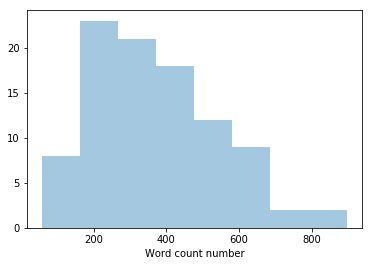

In [66]:
sns.distplot(offer_word_number, kde=False, norm_hist=False, axlabel="Word count number")

As a consequence, we need to define a specific word vocabulary in order to only retain the relevant terms related to data, education, work experience and skill. 
<br>
**Then the Dice metric will favorize job offers which present high number of word in common with the resume while penalyzing offers that are either too indefinite or too demanding in regards with the candidate resume.**
<br>
<br> 
For further information on text similarity measurement, a nice synthesis is available here [[8]](#ref8) (French only).

I defined a first pecific vocabulary adapted to my resume and my job searching.
<br> It should be improved in the future, especially in order to cover most of the hazardous spelling for technical skill or tool (e.g. "Scikit-learn" could also probably be found as "Sklearn" or "Scikit learn" in some job offers).

In [67]:
#programming languages usefull for data
prog_lang_l = ['Python', 'R', 'C', 'C#', 'C++', 'SAS', 'SPSS', 'VBA', 'SQL', 'NoSQL', 'Fortran', 'Matlab',
               'Perl', 'Julia', 'Ruby', 'Scala', 'Java', 'JavaScript', 'PHP', 'HTLM', 'CSS']

#other computing skills : IDE, OS, Big data Framework, Cloud Computing, Software BI & Data viz, Database, GIS/SIG, collab
other_comput_l = ['PyCharm', 'Jupyter', 'RStudio', 'Visual Studio',
                  'Windows', 'Linux', 'Mac', 'iOS', 'Android',
                  'Hadoop', 'MapReduce', 'Hive', 'Kafka', 'Spark', 'Pig',
                  'Azure', 'AWS', 'Google Cloud',
                  'Tableau', 'Power BI', 'Qlikview',
                  'HBase', 'Cassandra', 'MongoDB', 'Access', 'PostgreSQL', 'Oracle',
                  'SIG', 'MapInfo', 'ArcGIS', 'QGIS',
                  'Git', 'GitHub',
                  'Microsoft Office']

#Python and R main libraries for data (oriented in favor of python and my profile)
data_library_l = ['Numpy', 'Scipy', 'Pandas', ' Dyplr', 'Tidyr',
                  'Matplotlib', 'Seaborn', 'Plotly', 'Bokeh', 'ggplot2', 'Shiny',
                  'Theano', 'TensorFlow', 'Keras', 'Pytorch', 'Scikit-learn', 'Statsmodels',
                  'NLTK', 'Beautiful Soup', 'Selenium',
                  'OpenCV']

data_skills_l = ['Statistiques', 'Data mining', 'Data wrangling', 'Data visualization',
                 'Machine Learning', 'Deep Learning', 'Clustering', 'Computer vision', 'NLP']

education_l = ['Master', 'Ingénieur', 'Docteur',
               'Mathématiques', 'Informatiques', 'Physique', 'Chimie', 'Biologie',
               'économie', 'Marketing', 'Finance', 'Actuariat']

language_l = ['Français', 'Anglais', 'Allemand', 'Espagnol', 'Arabe', 'Chinois', 'Japonais']

gal_prof_skill_l = ['Gestion de projets', "Gestion d'affaires", 'Management',
                    'Rédaction', 'Présentation', 'Communication', 'Relationnel',
                    'Agile', 'Scrum'] # Add soft skills later ?

#Oriented according to my resume. Some are redundant with education -> not added
data_sectors_l = ['Ingénierie', 'Santé', 'énergie', 'Déchets', 'Transports', 'Industrie',#environnement tag too confusing
                  'Pharmaceutique', 'Biotechnologies',
                  'Smart city', 'IoT',
                  'Assurances', 'Banques',
                  'Publicité', 'Web', 'e-commerce',
                  'Grande distribution']

Let's compute all these sub-vocabularies into a general skill list

In [68]:
overall_skill_l = prog_lang_l + other_comput_l + data_library_l + data_skills_l + education_l + language_l + \
                  gal_prof_skill_l + data_sectors_l
overall_skill_l = [skill.lower() for skill in overall_skill_l]

In [69]:
len(overall_skill_l)

129

I used the CountVectorizer class provided by Scikit-learn with a special token pattern to handle compound nouns more easily (e.g. I do not want that "scikit-learn" stands for 2 words and received a double weight in comparison to Pandas for example).

In [70]:
tok_pattern = '\w+\-?\w*'
word_counter = CountVectorizer(strip_accents=None, lowercase=True,
                               analyzer='word', token_pattern=tok_pattern, ngram_range=(1, 2),
                               vocabulary=overall_skill_l, binary=True)
some_offer_corpus = [
    'Offre en économie vous devrez maitriser Power BI, les outils de Data visualization et parler Allemand',
    'Vous etes un chinois français en data science et machine learning (scikit-learn, pandas)'
]
X = word_counter.fit_transform(some_offer_corpus)

In [71]:
X.toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int64)

The word counter seems to work fine. We can use it to transform in advance all our job offers into a bag of specific words.
<br>
For the candidate resume, it will be provided later by the Bokeh user via an input file widget in order to compute the Dice similarity.

In [72]:
X_sim = word_counter.fit_transform(df_union['pos_descr'])
X_sim.shape

(95, 129)

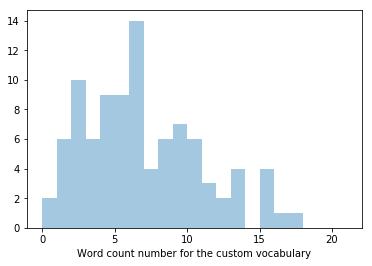

In [73]:
specific_offer_word_number = X_sim.sum(axis=1)
sns.distplot(specific_offer_word_number, kde=False, norm_hist=False, bins=range(np.max(X_sim.sum(axis=1))), 
             axlabel="Word count number for the custom vocabulary")

The word counter looks fine and will be saved as well as the bag of words array for the job offers just a moment later in the all in one function. Let's first define the necessary directory and file paths.

In [74]:
SKILL_WORD_COUNTER_DIR = './skill_word_counter'
os.makedirs(SKILL_WORD_COUNTER_DIR, exist_ok=True)
SKILL_WORD_COUNTER_PATH = os.path.join(SKILL_WORD_COUNTER_DIR, 'skill_word_counter.pkl')
X_SIM_PATH = os.path.join(SKILL_WORD_COUNTER_DIR, 'X_sim.pkl')   

<h4>c) All in one function</h4>
<a id="2.1.c"></a>

In [75]:
def create_or_update_df_union():
    """Create or update df union from each single job board database : from data import&cleaning to feature engineering.
    Also create/update the word counting sparse matrix for job_offers (used for Dice similarity)"""
    
    #First import all the jb board database
    DB_SAVING_DIR = './job_db'
    DB_APEC_NEW_SAVING_PATH = os.path.join(DB_SAVING_DIR, 'apec_new.xlsx')
    DB_INDEED_NEW_SAVING_PATH = os.path.join(DB_SAVING_DIR, 'indeed_new.xlsx')
    DB_UNION_SAVING_PATH = os.path.join(DB_SAVING_DIR, 'union_database.xlsx') #union of individual databases

    dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%Y') #to parse date format when importing the dataframe
    df={} # initiate the dict for the job database
    update = os.path.isfile(DB_UNION_SAVING_PATH)
    if update:
        file_name_pat='\*_new.xlsx' #only *_new.xlsx files (preprocessing task has been previously executed on an old db)
    else:
        file_name_pat='\*_db.xlsx' #only *_db.xlsx files (preprocessing task has never been executed before)
    
    for filepath in glob.glob(DB_SAVING_DIR + file_name_pat):
        name_origin = re.search(r'\w+(?=_(db|new)\.xlsx)', filepath).group()
        df[name_origin] = pd.read_excel(filepath, parse_dates=['pub_date'], date_parser=dateparse)
        df[name_origin]['origin'] = name_origin
        print("Raw data - {}: {} job offers".format(name_origin, len(df[name_origin])))
    
    #Proceed to some data cleaning
    mask={} #initiate the dict for boolean mask filtering
    mask['apec'] = df['apec']['job_title'].map(lambda x: re.match(r'.*\b(data|données?|bi|business intelligence)\b.*',
                                                                  str(x), flags=re.IGNORECASE)).notnull()
    mask['indeed'] = df['indeed']['pos_type'].map(lambda x: re.match(r'.*\b(stage|alternance|apprentissage)\b.*',
                                                                     str(x), flags=re.IGNORECASE)).isnull()
    for key in df.keys():
        df[key] = df[key][mask[key]]
        print("After filtering - {}: {} job offers".format(key, len(df[key])))    
      
    df['apec']['pos_descr'] = df['apec']['comp_info'] + '\n' + df['apec']['pos_descr'] + '\n' + df['apec']['profil']
    
    # Feature engineering
    ## City and Department
    df['apec']['city'], df['apec']['dept'] = zip(*df['apec']['location'].map(get_city_and_dept_apec))
    df['indeed']['city'], df['indeed']['dept'] = zip(*df['indeed']['location'].map(get_city_and_dept_indeed))
    
    df_union = pd.concat([df[key] for key in df.keys()], ignore_index=True, sort=False) #aggregate all the databases
    
    ## Region
    DEPT_PATH = './dpt_reg_fr.csv'
    DEPT_DL_URL = 'https://raw.githubusercontent.com/GuillaumeHarel/portfolio-projects/master/'\
                  '%231_Webscraping_%26_Bokeh/Auxiliary_files/Dept_Region_France.csv'
    urllib.request.urlretrieve(DEPT_DL_URL, DEPT_PATH)
    df_dept_reg = pd.read_csv(DEPT_PATH, dtype={'regionCode': 'Int32'})
    df_union = pd.merge(df_union, df_dept_reg[['departmentCode', 'departmentName', 'regionName']],
                        how='left', left_on='dept', right_on='departmentCode')
    df_union.drop('departmentCode', 1, inplace=True)
    
    ##Average Salary
    df_union['avg_sal'] = df_union['salary'].map(get_salary)
    
    ##Job categories
    df_union['job_cat'] = df_union['job_title'].map(get_cat_dummies)
    df_union[job_cat_labels] = pd.DataFrame(df_union['job_cat'].values.tolist(), index=df_union.index)
    
    ##Index
    df_union['index_0'] = df_union.index
    
    ##Similarity
    df_union['sim'] = np.NaN
    
    #Compute word counting sparse matrix for job offers (used later for Dice similarity)
    tok_pattern = '\w+\-?\w*'
    word_counter = CountVectorizer(strip_accents=None, lowercase=True,
                                   analyzer='word', token_pattern=tok_pattern, ngram_range=(1, 2),
                                   vocabulary=overall_skill_l, binary=True)
    X_sim = word_counter.fit_transform(df_union['pos_descr'])
    
    SKILL_WORD_COUNTER_DIR = './skill_word_counter'
    os.makedirs(SKILL_WORD_COUNTER_DIR, exist_ok=True)
    SKILL_WORD_COUNTER_PATH = os.path.join(SKILL_WORD_COUNTER_DIR, 'skill_word_counter.pkl')
    X_SIM_PATH = os.path.join(SKILL_WORD_COUNTER_DIR, 'X_sim.pkl')
    
    if update:
        with open(X_SIM_PATH, 'rb') as input:
            X_sim_db = pickle.load(input)
        X_sim_full = vstack([X_sim_db, X_sim])
        with open(X_SIM_PATH, 'wb') as output:
            pickle.dump(X_sim_full, output)
        with open(SKILL_WORD_COUNTER_PATH, 'wb') as output:
            pickle.dump(word_counter, output)
        print('\nWord counter transformer and word counting sparse matrix have been updated and saved')
        
    else:    
        with open(X_SIM_PATH, 'wb') as output:
            pickle.dump(X_sim, output)
        with open(SKILL_WORD_COUNTER_PATH, 'wb') as output:
            pickle.dump(word_counter, output)
        print('\nWord counter transformer and word counting sparse matrix have been created and saved')
    
    
    #Eventually save or update df_union
    if update:
        df_union_full = update_excel_file(DB_UNION_SAVING_PATH, df_union)
        for filepath in glob.glob(DB_SAVING_DIR + file_name_pat):
            os.remove(filepath) #avoid adding same new file twice
        print('\nDone: the Union DB has been updated and contains {} offers'.format(len(df_union_full)))
    else:
        with pd.ExcelWriter(DB_UNION_SAVING_PATH, options={'strings_to_urls': False}) as writer:
            df_union.to_excel(writer, index=False)
        print('\nDone: the Union DB has been created and contains {} offers'.format(len(df_union)))

In [76]:
create_or_update_df_union()

Raw data - apec: 17 job offers
Raw data - indeed: 94 job offers
After filtering - apec: 6 job offers
After filtering - indeed: 89 job offers

Word counter transformer and word counting sparse matrix have been updated and saved

Done: the Union DB has been updated and contains 5269 offers


**Data preprocessing is complete. It's time to build the Bokeh App for the custom aggregated job board.**

<h3>2) Custom aggregated job board using Bokeh</h3>
<a id="2.2"></a>

In order to have a nice interactive and synchronized dashboard for the job database, it is necessary to run a Bokeh server to handle our Bokeh App. This will keep the Bokeh model objects in python and in the browser in synchronization with each other, allowing to trigger callbacks to update data when control widgets are manipulated and respond to queries using the full power of python. It will also enable to include some nice custom CSS styling for the dashboard display in browser !
<br>
The different files required to properly run the Bokeh server and build our dashboard App will be presented in the current chapter section of the Notebook. 
<br>
**However, the Bokeh server must be run via the Windows terminal and all the necessary files must be placed in specific fold/subfolders of the current project directory as described in the Bokeh App architecture subchapter below**.
<br> 
It is not possible to run the Bokeh dashboard App for the aggregated job board directly from the Notebook.
<br> 
<br> 
For furter information, please read Bokeh documentation [[9]](#ref9) (especially the following user guide section : "Running a Bokeh Server", "Adding Interactions")
A very complete and didactical blog article to get hands on Bokeh is also available here: [[10]](#ref10), [[11]](#ref11), [[12]](#ref12)

<h4>a) Bokeh App architecture</h4>
<a id="2.2.a"></a>

It was necessary to use the "directory format" for the Bokeh App in order to include some custom CSS styling.
The name of my directory is web_scraping and it respects the following general architecture:

*main.py* contains the python code for the interactive dashboard App while the template subdirectory contains an *index.html* Jinja template file and *styles.css* file for custom css styling.
<br>
These three files are reproduced in the coming sub-chapter and are available in my GitHub repository.
<br>
<br>
To run the Bokeh server with the directory format Bokeh App, in Windows terminal :
* Activate the proper python environment;
* Change directory to the parent directory of the working directory;
* Run the following command:

```bokeh serve --show web_scraping
```

<h4>b) Bokeh App</h4>
<a id="2.2.b"></a>

**main.py** (*#not to be executed in the Notebook*)

In [ ]:
import re
import numpy as np
import pandas as pd
import datetime
import os
import base64
import pickle

from bokeh.models.widgets import HTMLTemplateFormatter, StringFormatter, DateFormatter
from bokeh.models.widgets import DataTable, TableColumn, RadioButtonGroup, TextInput, TextAreaInput, Dropdown,\
    RangeSlider, CheckboxGroup, Div, FileInput
from bokeh.models import ColumnDataSource, Panel, Tabs
from bokeh.io import curdoc
from bokeh.layouts import gridplot, column

#manage the directories and paths
PROJECT_DIR = './web_scraping'
DB_SAVING_DIR = os.path.join(PROJECT_DIR, 'job_db')
UNION_DB_PATH = os.path.join(DB_SAVING_DIR, 'union_database.xlsx')
SKILL_WORD_COUNTER_DIR = os.path.join(PROJECT_DIR, 'skill_word_counter')
WORD_COUNTER_PATH = os.path.join(SKILL_WORD_COUNTER_DIR, 'skill_word_counter.pkl')
JOB_OFFER_SPR_MATRIX_PATH = os.path.join(SKILL_WORD_COUNTER_DIR, 'X_sim.pkl')

#import df_union
df_union = pd.read_excel(UNION_DB_PATH)

#A few "metrics" and  labels for later
site_source = ['Apec', 'Indeed']
origin_source = ['All sites'] + site_source
total_job_numbers = [len(df_union)] + [len(df_union[df_union['origin'] == origin.lower()]) for origin in site_source]
min_salary = [(np.min(df_union['avg_sal'])//5-1)*5] + \
             [(np.min(df_union.loc[df_union['origin'] == origin.lower(), 'avg_sal'])//5-1)*5 for origin in site_source]

max_salary = [(np.max(df_union['avg_sal'])//5+1)*5] + \
             [(np.max(df_union.loc[df_union['origin'] == origin.lower(), 'avg_sal'])//5+1)*5 for origin in site_source]

location_choice = ["France", "Auvergne-Rhône-Alpes", "Rhône", "Lyon"]
location_scale_col = [None, 'regionName', 'departmentName', 'city'] #usefull later for RadioGroupbutton

job_cat_labels = ["Data scientist",
                  "Data analyst & BI",
                  "Big Data (engineer, dev, archi)",
                  "IT Project Manager (data related)",
                  "Data Manager/Officer",
                  "Unclassified"]

#column to keep to display in Bokeh App
ord_kept_columnns = ['index_0', 'pub_date', 'job_title', 'company', 'location', 'pos_type',
                     'nb_pos', 'req_exp', 'salary', 'act_area', 'url', 'sim']

#names of the kept columns to display in Bokeh App (datatable)
ord_names = ['#', 'Date', 'Title', 'Company', 'Location', 'Type',
             'Nb', 'Experience', 'Salary', 'Activity area', 'URL', 'Similarity']

#respective length of each column in Bokeh datatable (in px)
ord_kept_columnns_len = [30, 60, 120, 100, 110, 30,
                         20, 80, 80, 130, 35, 50]


#Define all column format for the Bokeh datatable
date_formatter = DateFormatter(format='%d/%m/%Y')
##URL format to display origin (e.g. apec, indeed) instead of URL link
url_formatter = HTMLTemplateFormatter(template='<a href="<%= url %>"><%= origin %></a>')
##Add a "hover" tool for datatable to display long text using a HTMLTemplateFormatter
template_long_text = """<span href="#" data-toggle="tooltip" title="<%= value %>"><%= value %></span>"""
text_tooltip = HTMLTemplateFormatter(template=template_long_text)
##One more HTLMTemplateFormatter with underscore js to customise font color of Dice similarity according to its value
template_sim = """
            <div style="color: <%= 
                    (function colorfromint(){
                        if(sim>0.4){return('green')}
                        else if (sim>0.2){return('orange')}
                        else if (sim>=0) {return('red')}
                        else {return('black')}
                        }()) %>;"> 
                <%= value %>
                </font>
            </div>
            """
template_sim_formatter = HTMLTemplateFormatter(template=template_sim)

index_formatter = StringFormatter(font_style='italic', text_align='right', text_color=(142, 142, 161))

formatters = [index_formatter] + [date_formatter] + [text_tooltip]*(len(ord_names)-4) + \
             [url_formatter] + [template_sim_formatter]



#TableColumn object necessary to build the Bokeh datatable
Columns = [TableColumn(field=Ci, title=Ti, width=Wi, formatter=Fi) for Ci, Ti, Wi, Fi in zip(
    ord_kept_columnns, ord_names, ord_kept_columnns_len, formatters)]


#custom template for a Div object that will be included in the Bokeh App to display the current number of job offers
template_div = ("""
      <div class='content'>
       <div class='name'> {site_name} </div>
        <span class='number'>{number}<small>/{total}</small> </span>
      </div>
      """)


#initiate all the dict that will contain widget objects.
# One panel per job board origin and one independent database for each panel!
cv_input = {}
location_select = {}
div_job_number = {}
select_1 = {}
select_2 = {}
select_3 = {}

df_source = {}
data_table_panel = {}
source = {}
table_row_1 = {}
table_row_2 = {}
table_row_3 = {}
table_row_4 = {}
table_bloc = {}
grid = {}
tab = {}

#age max for job offer age
age_max = "100000"

#build all widget objects and aggregate them in a grid plot for each panel (according to job board origin).
for idx, origin in enumerate(origin_source):
    cv_input[origin] = FileInput(accept='.txt')
    location_select[origin] = RadioButtonGroup(labels=location_choice, active=0,
                                               css_classes=['custom_group_button_bokeh'])
    text = template_div.format(site_name=origin,
                               number=total_job_numbers[idx],
                               total=total_job_numbers[idx])
    div_job_number[origin] = Div(text=text, height=50)
    select_1[origin] = Dropdown(value=age_max, label='Publication date', css_classes=['custom_button_bokeh'],
                                menu=[("All", age_max),
                                      ("Less than 1 day", "1"),
                                      ("Less than 3 days", "3"),
                                      ("Less than 7 days", "7"),
                                      ("Less than 14 days", "14"),
                                      ("Less than 30 days", "30")
                                      ]
                                )
    # WARNING for Dropdown button, use value param. to set default value (and not default_value param. !!!)

    select_2[origin] = CheckboxGroup(labels=job_cat_labels, active=list(range(len(job_cat_labels))))

    select_3[origin] = RangeSlider(title="Salary(k€)", start=min_salary[idx], end=max_salary[idx], step=5,
                                   value=(min_salary[idx], max_salary[idx]))

    if origin == 'All sites':
        df_source[origin] = df_union
    else:
        df_source[origin] = df_union[df_union['origin'] == origin.lower()]
    source[origin] = ColumnDataSource(df_source[origin])
    data_table_panel[origin] = DataTable(columns=Columns, source=source[origin],
                                         reorderable=True, fit_columns=True, index_position=None,
                                         width=1000, height=260, row_height=23,
                                         css_classes=["my-table"])
    table_row_1[origin] = TextInput(value='', title="Job title")
    table_row_2[origin] = TextInput(value='', title="Company")
    table_row_3[origin] = TextInput(value='', title="Location")
    table_row_4[origin] = TextInput(value='', title="Recruitment responsible")
    table_bloc[origin] = TextAreaInput(value='', title="Job description", cols=1000, max_length=5000, rows=11)
    grid[origin] = gridplot([[cv_input[origin], location_select[origin]],
                             [column(select_1[origin],
                                     select_2[origin],
                                     select_3[origin],
                                     div_job_number[origin]),
                              data_table_panel[origin]],
                             [column(table_row_1[origin],
                                     table_row_2[origin],
                                     table_row_3[origin],
                                     table_row_4[origin]),
                              table_bloc[origin]]])

    tab[origin] = Panel(child=grid[origin], title=origin)

tabs = Tabs(tabs=[tab[origin] for origin in origin_source])


def function_source(attr, old, new):
    """Display information in appropriate table_row/bloc Widgets on row selection in the datatable"""
    active_panel = origin_source[tabs.active]
    try:
        selected_index = source[active_panel].selected.indices[0]
        table_row_1[active_panel].value = str(source[active_panel].data["job_title"][selected_index])
        table_row_2[active_panel].value = str(source[active_panel].data["company"][selected_index])
        table_row_3[active_panel].value = str(source[active_panel].data["location"][selected_index])
        table_row_4[active_panel].value = str(source[active_panel].data["recruit_resp"][selected_index])
        table_bloc[active_panel].value = str(source[active_panel].data["pos_descr"][selected_index])
    except IndexError:
        pass


def make_dataset(offer_age, min_sal, max_sal, job_cat, loc):
    """Make a subset of the full dataset according to filters defined by user via Bokeh widgets"""
    data = df_source[origin_source[tabs.active]]
    today = pd.Timestamp.today().floor("D")
    min_date = today - datetime.timedelta(days=int(offer_age))
    date_mask = data['pub_date'].between(min_date, today)
    salary_mask = ((data['avg_sal'] >= min_sal) & (data['avg_sal'] <= max_sal)) | (data['avg_sal'].isnull())
    cat_mask = (data[job_cat] == 1).any(axis=1)
    if loc == 0:
        loc_mask = [True] * len(data)
    elif loc < 3:
        loc_mask = data[location_scale_col[loc]] == location_choice[loc]
    else:
        loc_mask = data[location_scale_col[loc]].map(lambda x: bool(re.match(location_choice[loc],
                                                                             str(x), flags=re.IGNORECASE)))
    sub_df = data[date_mask & salary_mask & cat_mask & loc_mask]
    return sub_df


def update_dpdown_label():
    """Updata dropdown button label according to user selection"""
    active_panel = origin_source[tabs.active]
    offer_age = select_1[active_panel].value
    if offer_age == age_max:
        new_label = "Publication date : All"
    else:
        new_label = "Publication date : Less than {} day(s)".format(offer_age)
    select_1[active_panel].label = new_label


def update_div_job_numbers():
    """Update job number display in the Div object according to current activated filters"""
    new_site_name = origin_source[tabs.active]
    new_number = len(source[origin_source[tabs.active]].data['index'])
    total = total_job_numbers[tabs.active]
    new_text = template_div.format(site_name=new_site_name,
                           number=new_number,
                           total=total)
    div_job_number[origin_source[tabs.active]].update(text=new_text)


def change_data_source():
    """Update the source datatable via the make_dataset function and filters provided by user via widgets"""
    active_panel = origin_source[tabs.active]
    offer_age = select_1[active_panel].value
    min_sal = select_3[active_panel].value[0]
    max_sal = select_3[active_panel].value[1]
    job_cat = [select_2[active_panel].labels[i] for i in select_2[active_panel].active]
    loc = location_select[active_panel].active
    new_src = make_dataset(offer_age=offer_age, min_sal=min_sal, max_sal=max_sal, job_cat=job_cat, loc=loc)
    source[active_panel].data.update(ColumnDataSource(new_src).data) #if passing directly the the new src in update, issue with index


def compute_similarity(cv, word_counter_path=WORD_COUNTER_PATH, offer_spr_matrix_path=JOB_OFFER_SPR_MATRIX_PATH):
    """ Transforms a resume into a word counting sparse matrix by a word counter (restricted vocabulary) and compute
    Dice index metric with word counting sparse matrix for job offers."""
    with open(word_counter_path, 'rb') as input:
        word_counter = pickle.load(input)
    with open(offer_spr_matrix_path, 'rb') as input:
        X_sim = pickle.load(input)
    Y = word_counter.transform([cv]) #word_counter iterates over raw text document, not raw text
    Z = X_sim.multiply(Y) #element-wise multiplication for sparse matrix
    sim_mat = 2 * Z.sum(axis=1)/(X_sim.sum(axis=1)+Y.sum())
    sim_arr = np.around(np.squeeze(np.asarray(sim_mat)), decimals=2) #convert matrix object into array
    D_sim = pd.Series(sim_arr, index=df_union.index)
    return D_sim


def update_similarity(attr, old, new):
    """Compute similarity between job offers and a resume provided by the user via the InputFile widget"""
    active_panel = origin_source[tabs.active]
    cv_64_enc_str = cv_input[active_panel].value
    # Encoding the Base64 encoded string into bytes
    cv_64_enc_b = cv_64_enc_str.encode('utf-8')
    # Decoding the Base64 bytes
    cv_enc_b = base64.b64decode(cv_64_enc_b)
    # Decoding the bytes to string
    cv_str = cv_enc_b.decode('utf-8')
    D_sim = compute_similarity(cv=cv_str)
    if active_panel != 'All sites':
        mask_origin = df_source['All sites']['origin'] == active_panel.lower()
        D_sim = D_sim[mask_origin]
    df_source[active_panel]['sim'] = D_sim
    change_data_source()

#triggers the functions according to widget modifications by user
for origin in origin_source:
    cv_input[origin].on_change("value", update_similarity)
    select_1[origin].on_change("value", lambda attr, old, new: change_data_source())
    select_1[origin].on_change("value", lambda attr, old, new: update_dpdown_label())
    select_3[origin].on_change("value", lambda attr, old, new: change_data_source())
    select_2[origin].on_change("active", lambda attr, old, new: change_data_source())
    location_select[origin].on_change("active", lambda attr, old, new: change_data_source())
    source[origin].selected.on_change('indices', function_source)
    source[origin].on_change('data', lambda attr, old, new: update_div_job_numbers())

curdoc().add_root(tabs)

**index.html**

<!DOCTYPE html>
<html lang="en">
    <head>
      <meta charset="utf-8">
      {{ bokeh_css }}
      {{ bokeh_js }}
      <style type="text/css">{% include 'styles.css' %}</style>
    </head>
    <body>
      {{ plot_div|indent(8) }}
      {{ plot_script|indent(8) }}
    </body>
</html>

**styles.css**

.content{
    color: #2b6980;      
    width: 100px;
    height: 30px;
	text-align:center;
	display:inline-block;
	background-color: #dbe7eb;
	font-weight: bold;
	position: absolute;
	left: 200px;
}

.name{
    font-size: 6pt;      
}

.number{
    font-size: 10pt;
}


.custom_button_bokeh button.bk.bk-btn.bk-btn-default {
	color: black;
	font-size: 9pt;
	background-color: #ff841278;
	border-color: #999;
	padding : 6px 32px;
}
.custom_button_bokeh div.bk.bk-menu.bk-below {
	position: absolute;
	left: 0;
	width: 100%;
	z-index: 100;
	cursor: pointer;
	font-size: 12px;
	background-color: #fff;
	border: 1px solid #ccc;
	border-radius: 4px;
	box-shadow: 0 6px 12px rgba(0,0,0,0.175);
	background-color: antiquewhite;
}

.custom_group_button_bokeh div.bk.bk-btn.bk-btn-default {
	color: black;
	font-size: 9pt;
	background-color: #b4cdd57a;
	border-color: #999;
	padding : 6px 32px;
}

.custom_group_button_bokeh div.bk.bk-btn.bk-btn-default.bk-active {
	color: black;
	font-size: 9pt;
	background-color: #a6cedb7a;
	border-color: #999;
	padding : 6px 32px;
	font-weight : bold;
}

.bk-root .bk-tabs-header .bk-tab.bk-active {
    color: #4d4d4d;
    background-color: #ffd26059;
    border-color: #e6e6e6;
    font-weight: bold;
}

.my-table .slick-header-column:nth-child(1) .slick-column-name{
    float:right !important;
}

**And the final result for the interactive Bokeh dashboard for the aggregated job board in action:**

![Bokeh_Gif_URL](https://s3.gifyu.com/images/bokeh.gif "Bokeh dashboard sample")

<h2>III) Exploratory data analysis (on going...)</h2>
<a id="3"></a>

***
<h2><u>Useful links</u></h2>

[1] https://selenium-python.readthedocs.io/index.html#
<a id="ref1"></a>

[2] https://www.crummy.com/software/BeautifulSoup/bs4/doc/
<a id="ref2"></a>

[3] http://jonathansoma.com/lede/foundations-2018/classes/selenium/selenium-windows-install/
<a id="ref3"></a>

[4] https://medium.com/ymedialabs-innovation/web-scraping-using-beautiful-soup-and-selenium-for-dynamic-page-2f8ad15efe25
<a id="ref4"></a>

[5] http://sametmax.com/parser-du-html-avec-beautifulsoup/
<a id="ref5"></a>

[6] http://blogs.quovantis.com/how-to-write-awesome-xpaths-for-test-automation-in-selenium/
<a id="ref6"></a>

[7] https://www.pluralsight.com/guides/web-scraping-with-selenium
<a id="ref2"></a>

[8] https://hal.archives-ouvertes.fr/hal-00874280/document
<a id="ref8"></a>

[9] https://bokeh.pydata.org/en/latest/docs/user_guide.html
<a id="ref9"></a>

[10] https://towardsdatascience.com/data-visualization-with-bokeh-in-python-part-one-getting-started-a11655a467d4
<a id="ref10"></a>

[11] https://towardsdatascience.com/data-visualization-with-bokeh-in-python-part-ii-interactions-a4cf994e2512
<a id="ref11"></a>

[12] https://towardsdatascience.com/data-visualization-with-bokeh-in-python-part-iii-a-complete-dashboard-dc6a86aa6e23
<a id="ref12"></a>